Pipelines: Light Parametric + Mass Light Dark + Source Parametric
=================================================================

By chaining together three searches this script fits strong lens `Imaging`, where in the final model:

 - The lens galaxy's light is a parametric `EllSersic`.
 - The lens galaxy's stellar mass distribution is tied to the light model above.
 - The lens galaxy's dark matter mass distribution is a `SphNFW`.
 - The source galaxy's light is a parametric `EllSersic`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

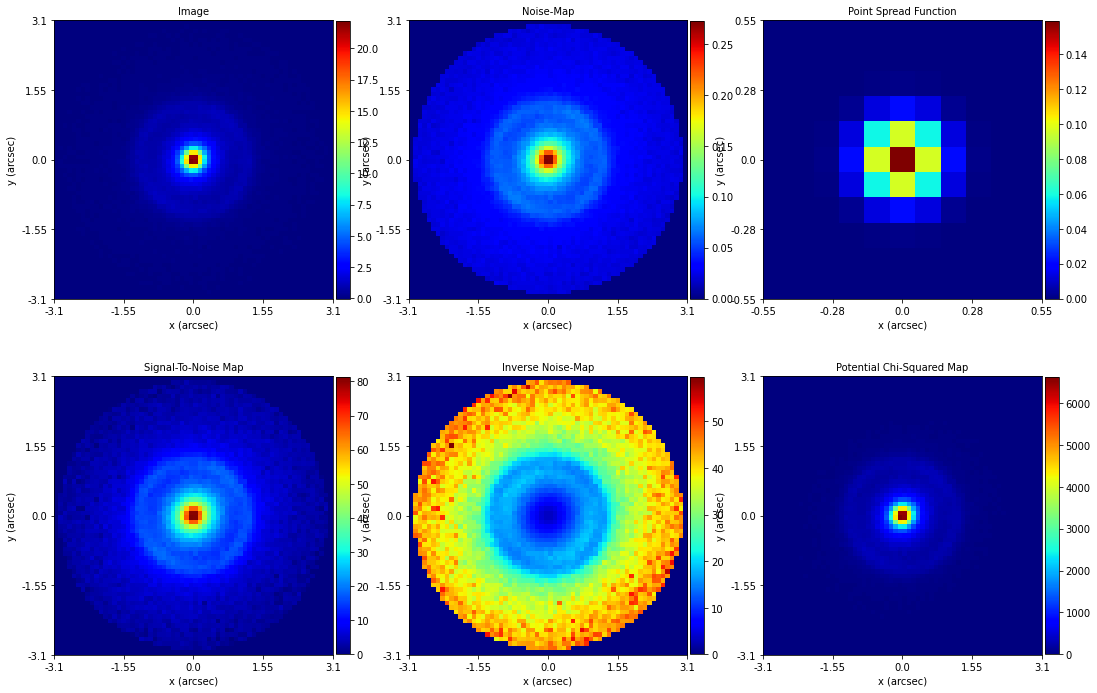

In [2]:
dataset_name = "light_sersic__mass_mlr_nfw__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "pipelines", dataset_name)

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In this analysis, they are used to explicitly set the `mass_at_200` of the elliptical NFW dark matter profile, which is
a model parameter that is fitted for.

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__Model + Search + Analysis + Model-Fit (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's light is a parametric `EllSersic` bulge [7 parameters].
 
 - The lens galaxy's mass and source galaxy are omitted.

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=11.

In [5]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(al.Galaxy, redshift=0.5, bulge=af.Model(al.lp.EllSersic))
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[1]_light[parametric]", nlive=50
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.11it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -3849.033 <    inf | logz: -3853.698 +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's light and stellar mass is a parametric `EllSersic` bulge [parameters fixed to result of 
 search 1].
 
 - The lens galaxy's dark matter mass distribution is a `EllNFWMCRLudlow` whose centre is aligned with the 
 `EllSersic` bulge and stellar mass model above [3 parameters].
 
 - The lens mass model also includes an `ExternalShear` [2 parameters].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12.

NOTES:

 - By using the fixed `bulge` model from the result of search 1, we are assuming this is a sufficiently accurate fit
 to the lens's light that it can reliably represent the stellar mass.

In [6]:
bulge = result_1.instance.galaxies.lens.bulge

dark = af.Model(al.mp.EllNFWMCRLudlow)
dark.centre = bulge.centre
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = redshift_lens
dark.redshift_source = redshift_source

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=0.5,
            bulge=bulge,
            dark=af.Model(al.mp.EllNFW),
            shear=al.mp.ExternalShear,
        ),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]_light[fixed]_mass[light_dark]_source[parametric]",
    nlive=75,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 31.73it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.084]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 3)__

We use the results of searches 1 and 2 to create the lens model fitted in search 3, where:

 - The lens galaxy's light and stellar mass is a parametric `EllSersic` bulge [8 parameters: priors initialized 
 from search 1].
 
 - The lens galaxy's dark matter mass distribution is a `EllNFWMCRLudlow` whose centre is aligned with the 
 `EllSersic` bulge and stellar mass model above [3 parameters: priors initialized from search 2].
 
 - The lens mass model also includes an `ExternalShear` [2 parameters: priors initialized from search 2].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters: priors initialized from search 2].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=22.

Notes:

 - This search attempts to address any issues there may have been with the bulge's stellar mass model.

In [7]:
bulge = result_1.model.galaxies.lens.bulge

dark = result_2.model.galaxies.lens.dark
dark.centre = bulge.centre

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=0.5,
            bulge=bulge,
            dark=dark,
            shear=result_2.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy, redshift=1.0, bulge=result_2.model.galaxies.source.bulge
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[3]_light[parametric]_mass[light_dark]_source[parametric]",
    nlive=75,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_3 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 32.01it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.084]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


Finish.